In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

Partie 1: Chargement et exploration des données

In [4]:
# 1 Chargez le jeu de données "arbres.csv" dans un DataFrame
df = pd.read_csv("p2-arbres-fr.csv",sep=";")

In [21]:
# 2 Affichez les premières lignes et les informations générales sur les colonnes (types de données, valeurs manquantes).
print(df.head())
print(df.describe())
print(df.info())
print("Valeurs manquantes:\n", df.isna().sum()) # valeurs maquantes sur chaque ligne
print("Pourcentage des valeurs manquantes :\n", df.isna().mean() * 100)

      id type_emplacement domanialite   arrondissement complement_addresse  \
0  99874            Arbre      Jardin   PARIS 7E ARRDT                 NaN   
1  99875            Arbre      Jardin   PARIS 7E ARRDT                 NaN   
2  99876            Arbre      Jardin   PARIS 7E ARRDT                 NaN   
3  99877            Arbre      Jardin   PARIS 7E ARRDT                 NaN   
4  99878            Arbre      Jardin  PARIS 17E ARRDT                 NaN   

   numero                                        lieu id_emplacement  \
0     NaN   MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E             19   
1     NaN   MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E             20   
2     NaN   MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E             21   
3     NaN   MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E             22   
4     NaN  PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING       000G0037   

  libelle_francais      genre         espece variete  circonference_cm  \
0       Marronnier   Aes

In [22]:
# 3 Identifiez les colonnes potentiellement utiles pour l'analyse (pensez à l'espèce, la localisation, la taille, l'âge, etc.).
print(df.columns)
df_clean = df[['domanialite', 'arrondissement',
       'lieu', 'id_emplacement', 'remarquable', 'stade_developpement',
       'libelle_francais', 'genre', 'espece', 'circonference_cm',
       'hauteur_m', 'geo_point_2d_a',
       'geo_point_2d_b']] # colone supprimer Id, type_emplacement, numero, complement_addresse, Variete

Index(['id', 'type_emplacement', 'domanialite', 'arrondissement',
       'complement_addresse', 'numero', 'lieu', 'id_emplacement',
       'libelle_francais', 'genre', 'espece', 'variete', 'circonference_cm',
       'hauteur_m', 'stade_developpement', 'remarquable', 'geo_point_2d_a',
       'geo_point_2d_b'],
      dtype='object')


In [23]:
# Vérification des doublons
duplicates = df_clean.duplicated().sum()

In [24]:
# Suppression des lignes où les informations critiques sont manquantes
critique_columns = ['genre', 'espece', 'circonference_cm', 'hauteur_m', 'geo_point_2d_a', 'geo_point_2d_b']
df_clean = df_clean.dropna(subset=critique_columns)

Partie 2 : Ananlyse descriptive

In [25]:
#Gestion des outliers
hauteur_max = 42 #m
circ_max = 1220 #cm

In [26]:
# Gestion des outliers
def get_outliers_max(var_label):

    # suppression des valeurs anormales grâce aux valeurs connues
    if var_label == 'circonference_cm':
        data = df_clean.query('circonference_cm > @circ_max')['circonference_cm']
    elif var_label == 'hauteur_m':
        data = df_clean.query('hauteur_m > @hauteur_max')['hauteur_m']

    return data

In [27]:
# Sélection des outliers
## Max
out_circ = get_outliers_max('circonference_cm')
out_h = get_outliers_max('hauteur_m')

In [28]:
# Affichage des outliers
print(f'{out_circ.shape[0]} outliers circonférence')
print(f'{out_h.shape[0]} outliers hauteurs')

41 outliers circonférence
480 outliers hauteurs


In [29]:
# Suppression des outliers du dataset
def remove_outliers(dataset, var_label):
    if var_label == 'circonference_cm':
        dataset = dataset[dataset['circonference_cm'] <= circ_max]
    elif var_label == 'hauteur_m':
        dataset = dataset[dataset['hauteur_m'] <= hauteur_max]

    return dataset

In [31]:
# Suppression des outliers pour chaque variable
df_clean = remove_outliers(df_clean, 'circonference_cm')
df_clean = remove_outliers(df_clean, 'hauteur_m')

In [32]:
# Vérification que les outliers ont été supprimés
print(f"Dataset après suppression des outliers : {df_clean.shape}")
# II Ananlyse descriptive
# Statistiques descriptives de base pour les colonnes pertinentes
print(df_clean[['circonference_cm', 'hauteur_m']].describe())


Dataset après suppression des outliers : (197866, 13)
       circonference_cm      hauteur_m
count      197866.00000  197866.000000
mean           80.25867       8.356706
std            64.54718       6.192783
min             0.00000       0.000000
25%            30.00000       5.000000
50%            70.00000       8.000000
75%           115.00000      12.000000
max          1220.00000      42.000000


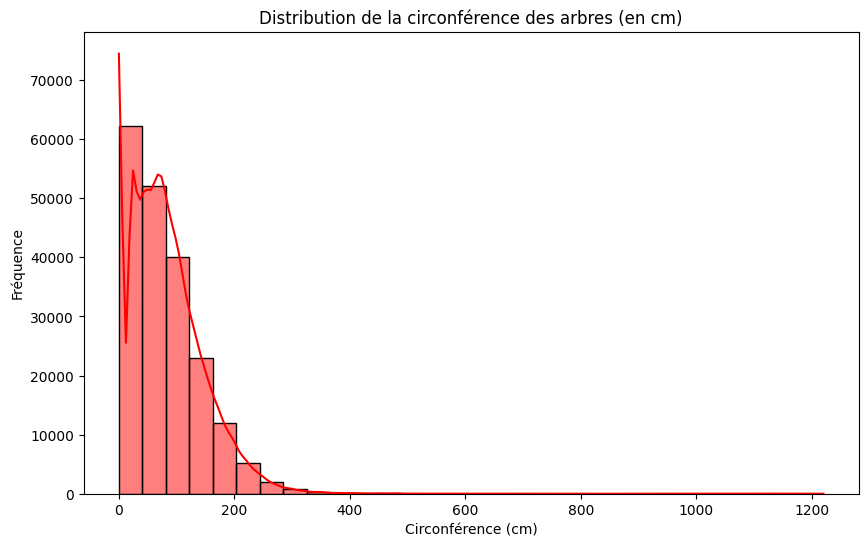

In [33]:
# Visualisation : histogramme de la circonférence
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['circonference_cm'], bins=30, kde=True, color='red')
plt.title('Distribution de la circonférence des arbres (en cm)')
plt.xlabel('Circonférence (cm)')
plt.ylabel('Fréquence')
plt.show()

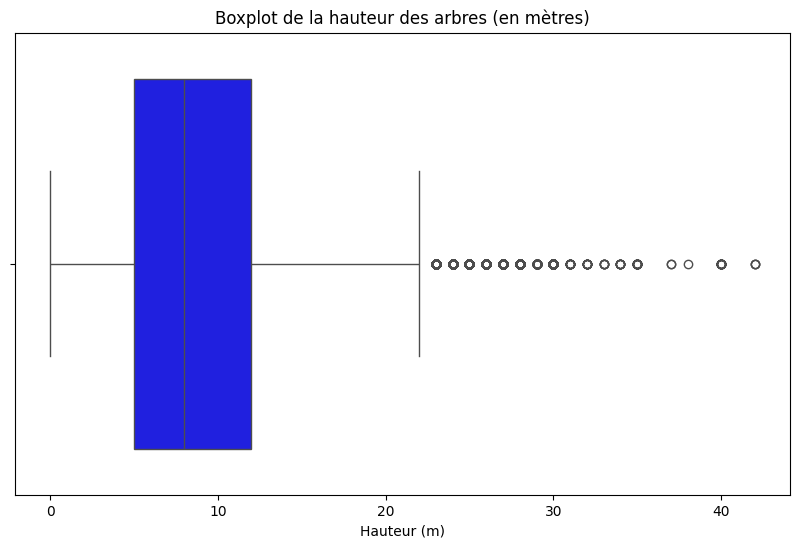

In [34]:
# Visualisation : boxplot de la hauteur
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_clean['hauteur_m'], color='blue')
plt.title('Boxplot de la hauteur des arbres (en mètres)')
plt.xlabel('Hauteur (m)')
plt.show()

<ipython-input-36-c7ab45805998>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=genre_counts.index, x=genre_counts.values, palette='viridis')


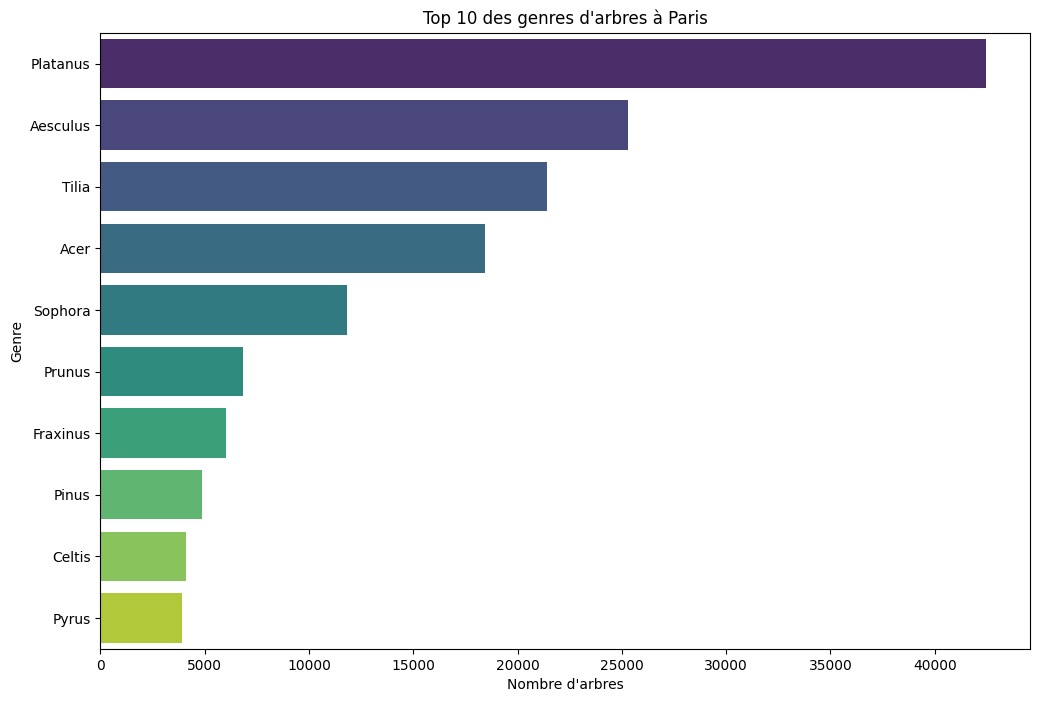

In [36]:
# Distribution des genres d'arbres (diagramme en barres)
plt.figure(figsize=(12, 8))
genre_counts = df_clean['genre'].value_counts().head(10)  # Top 10 genres
sns.barplot(y=genre_counts.index, x=genre_counts.values, palette='viridis')
plt.title('Top 10 des genres d\'arbres à Paris')
plt.xlabel('Nombre d\'arbres')
plt.ylabel('Genre')
plt.show()

Partie 3 : Analyse bivariée et identification des relations

In [37]:
# Calculer la matrice de corrélation pour les colonnes numériques pertinentes
correlation_matrix = df_clean[['circonference_cm', 'hauteur_m']].corr()

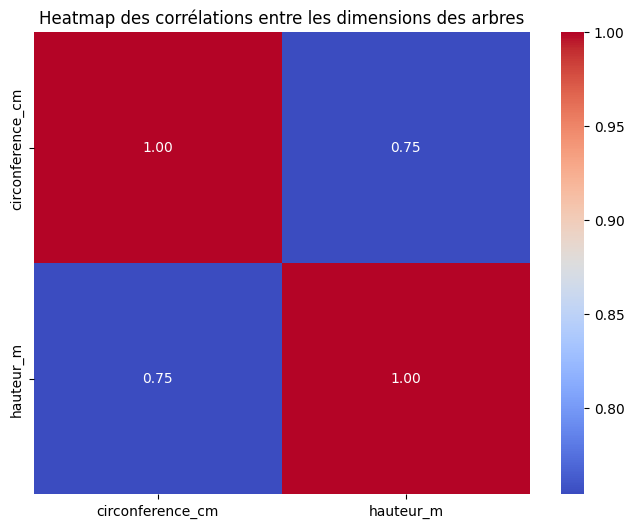

In [38]:
# Visualisation : heatmap des corrélations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Heatmap des corrélations entre les dimensions des arbres')
plt.show()

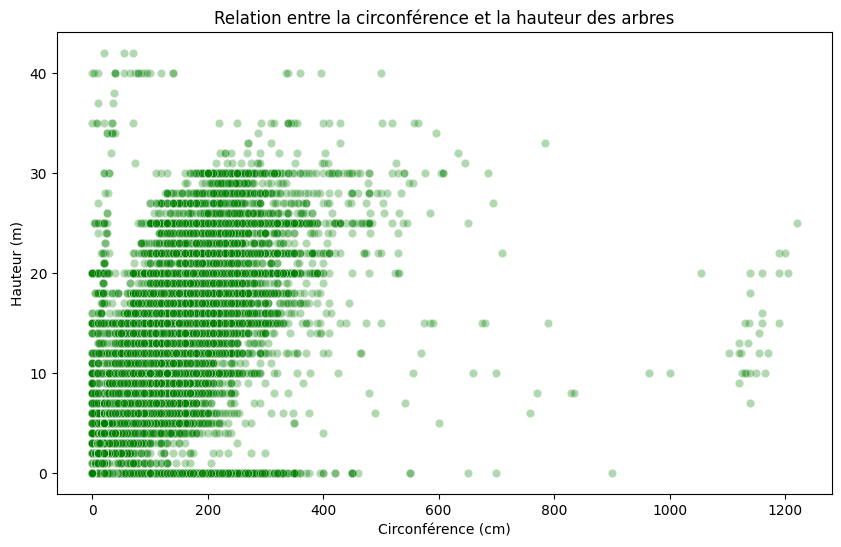

In [40]:
# Visualisation : nuage de points pour circonférence vs hauteur
plt.figure(figsize=(10, 6))
sns.scatterplot(x='circonference_cm', y='hauteur_m', data=df_clean, alpha=0.3, color='green')
plt.title('Relation entre la circonférence et la hauteur des arbres')
plt.xlabel('Circonférence (cm)')
plt.ylabel('Hauteur (m)')
plt.show()

Partie 3 : Analyse Spatial

In [41]:
# Créer une carte centrée sur Paris
mean_lat = df_clean['geo_point_2d_a'].mean()
mean_lon = df_clean['geo_point_2d_b'].mean()
paris_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

In [42]:
# Ajouter une HeatMap
heat_data = df_clean[['geo_point_2d_a', 'geo_point_2d_b']].values.tolist()
HeatMap(heat_data, radius=10).add_to(paris_map)

In [43]:
# Sauvegarder la carte
paris_map.save("paris_trees_map.html")
print("Carte sauvegardée sous paris_trees_map.html")

Carte sauvegardée sous paris_trees_map.html


In [45]:
# Calculer le nombre d'arbres par arrondissement
arbres_par_arrondissement = df_clean.groupby('arrondissement')['hauteur_m'].count()

In [46]:
# Identifier l'espèce dominante par arrondissement (mode)
espèce_dominante = df_clean.groupby('arrondissement')['espece'].agg(lambda x: x.mode()[0])

In [47]:
# Créer un DataFrame avec les résultats combinés
resultat = pd.DataFrame({
    'nombre_arbres': arbres_par_arrondissement,
    'espece_dominante': espèce_dominante
}).reset_index()

<Axes: xlabel='nombre_arbres', ylabel='arrondissement'>

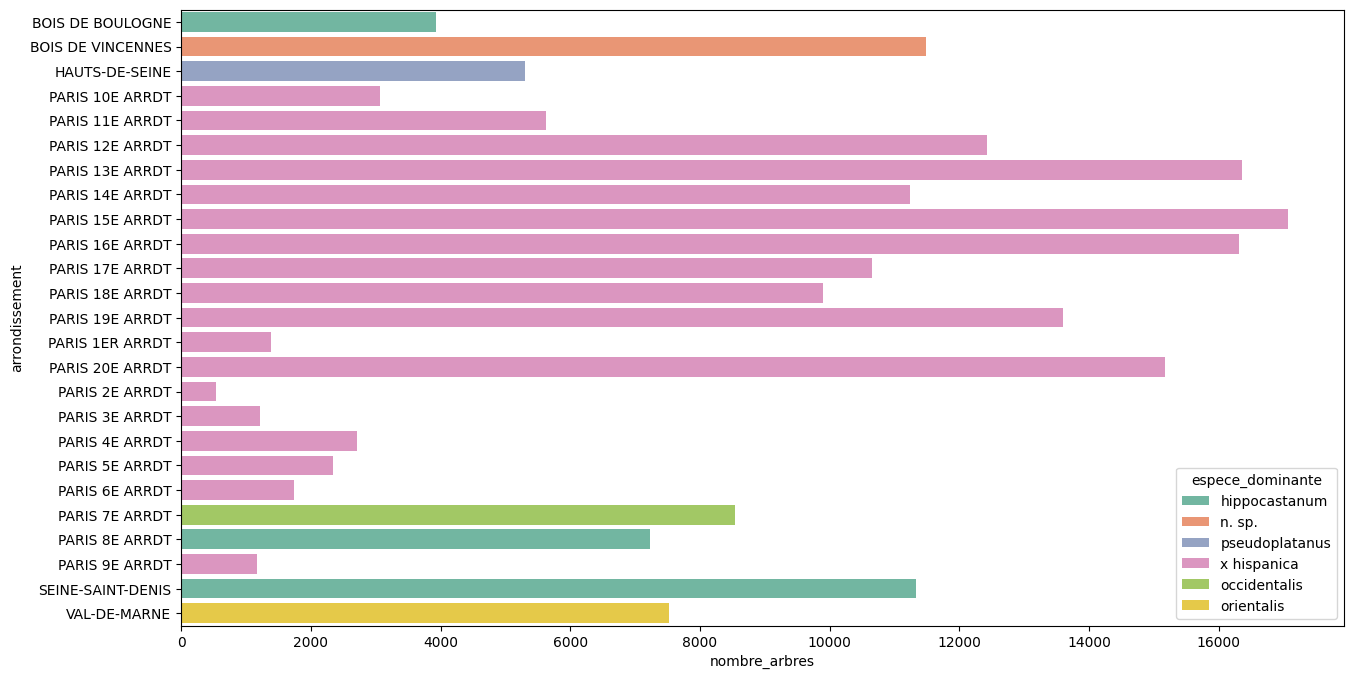

In [48]:
# Visualiser la relation : Nombre d'arbres vs Espèce dominante
plt.figure(figsize=(15, 8))
sns.barplot(x='nombre_arbres', y='arrondissement', hue='espece_dominante', data=resultat, dodge=False, palette="Set2")


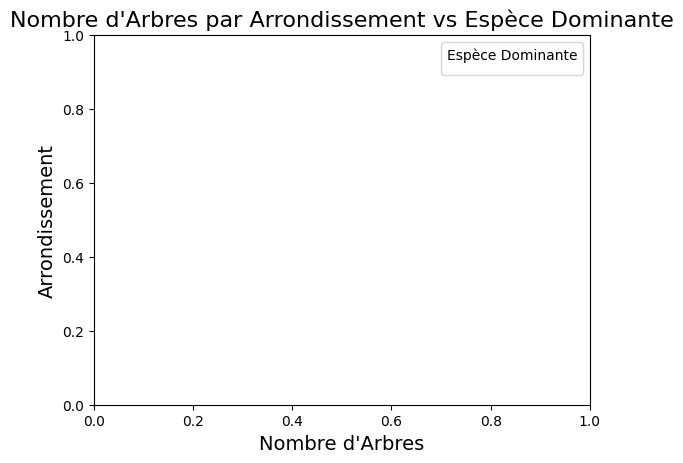

In [50]:
# Ajouter des titres et labels
plt.title("Nombre d'Arbres par Arrondissement vs Espèce Dominante", fontsize=16)
plt.xlabel("Nombre d'Arbres", fontsize=14)
plt.ylabel("Arrondissement", fontsize=14)
plt.legend(title='Espèce Dominante')
# Afficher le graphique
plt.show()

In [51]:
# Compter les espèces par arrondissement
species_counts = df_clean.groupby('arrondissement')['espece'].value_counts().unstack().fillna(0)

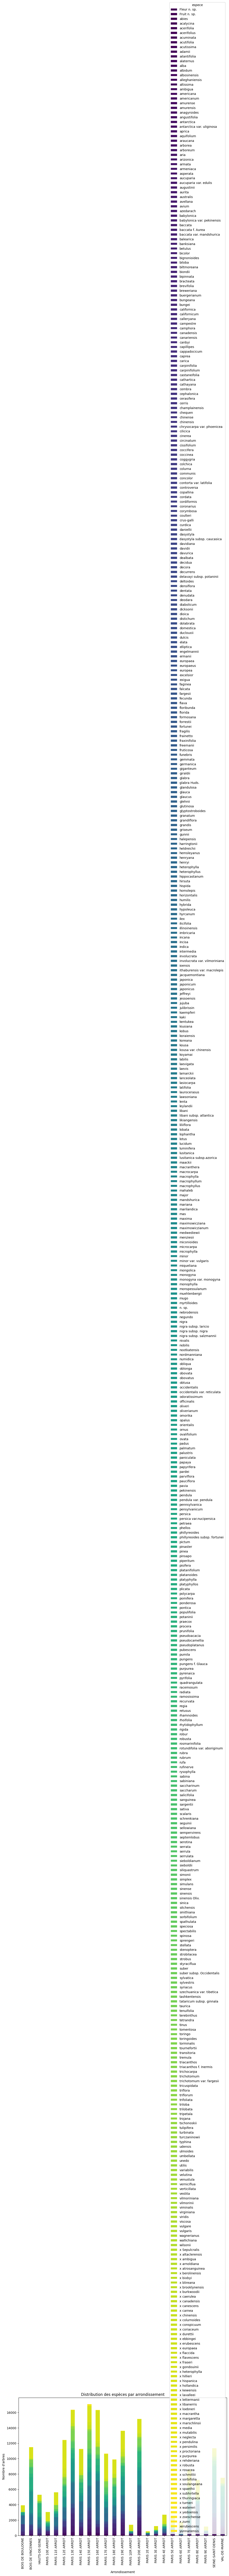

In [52]:
# Visualisation
species_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="viridis")
plt.title("Distribution des espèces par arrondissement")
plt.xlabel("Arrondissement")
plt.ylabel("Nombre d'arbres")
plt.show()